## Lab 5: PCA and Text Analysis
Hanna Svenson (jda6qt)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

### Q1. 

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents. 

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

In [2]:
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
df.head()

,index,Unnamed: 0,Email Text,Email Type
0,0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [3]:
tokens = df['Email Text'].str.split()
tokens.head()

0    [re, :, 6, ., 1100, ,, disc, :, uniformitarian...
1    [the, other, side, of, *, galicismos, *, *, ga...
2    [re, :, equistar, deal, tickets, are, you, sti...
3    [Hello, I, am, your, hot, lil, horny, toy., I,...
4    [software, at, incredibly, low, prices, (, 86,...
Name: Email Text, dtype: object

To clean the tokens, I would want to remove words or symbols that would not be strong indicators of whether an email was a scam or not. I would remove words like "and", "the", "a", "to", "it", and so on. Commas and periods could also be removed. Then I would use one-hot encoding and use the data to find what tokens are highly predictive of phishing emails vs not. 

### Q2. 

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [12]:
import pickle
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()
# token_freq

count    48691.000000
mean         5.687889
std         27.717476
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       1365.000000
Name: frequency, dtype: float64

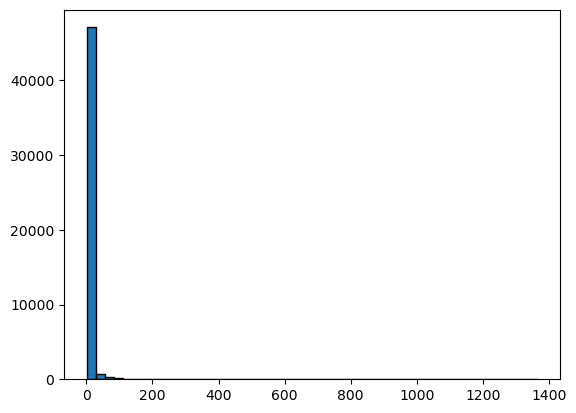

In [5]:
token_df = pd.DataFrame(token_freq, columns=['token', 'frequency'])
plt.hist(token_df['frequency'], bins=50, edgecolor='black')
token_df['frequency'].describe()


Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?


75% of all tokens appear 2 times or less, and 50% occur 1 time. This results in a histogram with a long tail.


### Q3. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [6]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
df = pd.read_parquet('Phishing_clean.parquet')
df.head()

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
y = df['Email Type']
X = df.drop(columns=['Email Type'])
X_train, X_test, y_train, y_test = train_test_split(X,y, # Feature and target variables
                                                    test_size=.2, # Split the sample 80 train/ 20 test
                                                    random_state=100) # For replication purposes

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (14907, 2711) (14907,)
Test set shape: (3727, 2711) (3727,)


In [8]:
from sklearn.linear_model import LinearRegression # Import linear regression model
reg = LinearRegression().fit(X_train, y_train) # Fit the linear model
results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_}) # Regression coefficients
print('R-squared train: ', reg.score(X_train, y_train)) # R squared measure
print('R-squared test: ', reg.score(X_test, y_test)) # R squared measure

R-squared train:  0.7678710315357768
R-squared test:  -1.120083521763337e+22


In [9]:
results['abs_coefficient'] = results['coefficient'].abs()
results = results.sort_values(by='abs_coefficient', ascending=False)
results.head(10)

,variable,coefficient,abs_coefficient
1570,400,-1.328579e+13,1.328579e+13
2454,750,-1.179193e+13,1.179193e+13
72,1998,1.085713e+13,1.085713e+13
497,713,-1.047574e+13,1.047574e+13
1695,1000,-9.207864e+12,9.207864e+12
1672,"cbs,",-9.128830e+12,9.128830e+12
1673,"cnn,",7.991303e+12,7.991303e+12
1745,"23,",7.854934e+12,7.854934e+12
1557,2003,-7.852553e+12,7.852553e+12
340,2005,-7.232869e+12,7.232869e+12


The tokens with the strongest influence are actually just numbers, and not words. We see from the R^2 value of the test data that the model does not perform well on new data, so this indicates that these aren't actually good indicators. 

### Q4. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

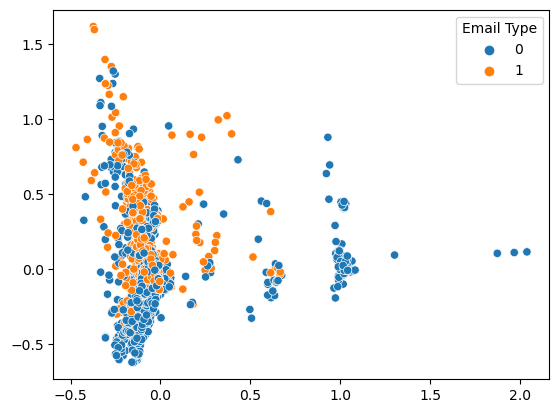

In [10]:
import seaborn as sns

## Housing PCA with sci-kit:
from sklearn.decomposition import PCA # Import PCA class
pca = PCA(n_components = 2) # Create PCA instance
pca = pca.fit(X_train) # Create the decomposition
Z_train = pca.transform(X_train) # Project house data; could use new data or test data
Z_test = pca.transform(X_test) # Project house data; could use new data or test data

sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

As a pattern, we see that the orange dots (the scam emails) have values on the x axis less than 1, whereas the blue dots will go beyond this value.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [11]:
pca = PCA(n_components = 2610) # Create PCA instance
pca = pca.fit(X_train) # Create the decomposition
Z_train = pca.transform(X_train) # Project house data; could use new data or test data
Z_test = pca.transform(X_test) # Project house data; could use new data or test data

reg = LinearRegression().fit(Z_train, y_train) # Fit the linear model
# results = pd.DataFrame({
#     'variable': [f'PC{i+1}' for i in range(pca.n_components_)],  # Naming components as PC1, PC2, ...
#     'coefficient': reg.coef_
# })
print('R-squared train: ', reg.score(Z_train, y_train)) # R squared measure
print('R-squared test: ', reg.score(Z_test, y_test)) # R squared measure

# results['abs_coefficient'] = results['coefficient'].abs()
# results = results.sort_values(by='abs_coefficient', ascending=False)
# print(results.head(10))

R-squared train:  0.7673333826623814
R-squared test:  0.659709533775608


This approach had much higher R^2 value for the test data than for the linear regression. This approach brings us R^2 values for train and test data that are pretty close together.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

PCA allows us to de-correlate the data and scale down the complexity. For k features or covariates, there would be 2^k choices of subsets for the variable for regression, compared to K ways to choose the first 2160 principal components for our model. However, a drawback is that there isn't a meaningful interpretation of what the components are, wheras we could look at the tokens for a linear regression.